In [1]:
import argparse
import logging
import math
import os
import random
import shutil
import yaml
import shutil
import json
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import sys
sys.path.append("./diffusers")

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

import pickle
import uuid

from projector import Projector

torch.autograd.set_detect_anomaly(True)

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/Diploma/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/Diploma/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
    PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
    }

In [3]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str = None, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")
    
def save_progress(projector, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_projector = (
        accelerator.unwrap_model(projector)
    )

    torch.save(learned_projector, save_path)


human_templates = [
    "a photo of a {}",
    "a portrait of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a beautiful {}",
    "a realistic photo of a {}",
    "a dark photo of the {}",
    "a character photo of a {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a face photo of the {}",
    "a cropped face of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a high-quality photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "an image of a {}",
    "a snapshot of a {}",
    "a person's photo of a {}",
    "an individual's photo of a {}",
]


In [114]:
def make_zone(size):
    zone = np.zeros(shape=(5, 4, size,size))
    for i1 in range(5):
        for i2 in range(4):
            for i in range(size):
                for j in range(size):
                    zone[i1, i2, i,j] \
                    = 1/(1 + np.e**(-((j-size/2)/(size/4))**2 - ((i-size/3)/(size/4))**2)) * (1 - 1/(1 + np.e**(-((j-size/2)/(size/4))**2 -((i-size/3)/(size/4))**2))) * 4
    return zone
    
# input: latent_sequence(con&uncon), prompt_embed, prompt, base_prompt
class OneActorDataset(Dataset):
    def __init__(
        self,
        target_dir,
        config,
        use_mask=False,
        repeats=50,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
    ):
        self.target_root = target_dir
        self.learnable_property = config['concept_type']
        self.size = config['size']
        self.latent_size = 128
        self.base_condition = config['base']
        self.flip_p = flip_p
        self.neg_num = config['neg_num']
        self.use_mask = use_mask
        
        self.image_paths = [
            os.path.join(self.target_root, file_path) for file_path in os.listdir(self.target_root) \
                if os.path.splitext(file_path)[1] == '.jpg']
        if self.use_mask:
            self.mask_image_paths = [f[:-4] + "_mask.png" for f in self.image_paths]
        self.base_root = self.target_root + '/base'
        self.base_paths = [
            os.path.join(self.base_root, file_path) for file_path in os.listdir(self.base_root) \
                if os.path.splitext(file_path)[1] == '.jpg']

        self.num_images = len(self.image_paths)
        self.num_base = len(self.base_paths)
        self._length = self.num_images * 2

        if set == "train":
            self._length = self.num_images * repeats * 2

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]
        if self.learnable_property == 'character':
            self.templates = human_templates
        elif self.learnable_property == 'object':
            self.templates = imagenet_templates_small
        elif self.learnable_property == 'style':
            self.templates = imagenet_style_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)    # randomly flip images

        with open(self.target_root+f'/xt_list.pkl', 'rb') as f:
            xt_dic = pickle.load(f)

        self.h_mid = xt_dic['h_mid']
        self.prompt_embed = xt_dic['prompt_embed']

        with open(self.base_root+f'/mid_list.pkl', 'rb') as f:
            self.base_mid = pickle.load(f)


    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        img_paths = []
        h_mid_list = []
        # target samples
        
        if self.use_mask:
            mask_tensor = []
            target_img_path, mask_target_img_path = random.choice(list(
                zip(self.image_paths, self.mask_image_paths))
            )
        else:
            target_img_path = random.choice(self.image_paths)
            
        img_paths.append(target_img_path)

        h_mid_list.append(self.h_mid[-1])
        # base samples
        for i in range(self.neg_num):
            ind = random.randint(0, len(self.base_paths)-1)
            img_paths.append(self.base_paths[ind])
            h_mid_list.append(self.base_mid[ind])
        h_mid_list.append(random.choice(h_mid_list))
        
        img_tensors = []
        text_list = []
        flip_ind = []
            
        for img_path in img_paths:

            image = Image.open(img_path)

            if not image.mode == "RGB":
                image = image.convert("RGB")
            # default to score-sde preprocessing
            image = np.array(image).astype(np.uint8)
            image = Image.fromarray(image)
            image = image.resize((self.size, self.size), resample=self.interpolation)
            image_f = self.flip_transform(image)
            _flip_ind = image_f != image
            flip_ind.append(_flip_ind)

            image = image_f
            image = np.array(image).astype(np.uint8)
            image = (image / 127.5 - 1.0).astype(np.float32)

            img_tensors.append(torch.from_numpy(image).permute(2, 0, 1))

            text = random.choice(self.templates).format(self.base_condition)
            text_list.append(text)

        if self.use_mask:
            mask_tensors = []
            mask = Image.open(mask_target_img_path)
            if not mask.mode == "RGB":
                mask = mask.convert("RGB")
                mask = np.array(mask).astype(np.uint8)
            if flip_ind[0]:
                mask = mask[:,::-1]
            # default to score-sde preprocessing
    
            mask = Image.fromarray(mask)
            mask = mask.resize((self.latent_size, self.latent_size), resample=self.interpolation)
            mask = np.array(mask).astype(np.uint8)
            mask = (mask / np.max(mask) ).astype(np.float32)
            mask = np.concatenate((mask, mask[:,:,:1]), axis=2) # make 4 channels
     
            mask_tensors.append(torch.from_numpy(mask).permute(2, 0, 1))
            for i in range(len(img_tensors) - len(mask_tensors)):
                mask_tensors.append(torch.ones(size=mask.shape).permute(2, 0, 1))
            mask_tensors.append(mask_tensors[0])

        img_tensors.append(img_tensors[0])
        text_list.append(text_list[0])

        example["pixel_values"] = torch.stack(img_tensors)
        if self.use_mask:
            example["mask_pixel_values"] = torch.stack(mask_tensors)
        example['text'] = text_list
        example['base'] = self.base_condition
        example['h_mid'] = torch.stack(h_mid_list)
    
        return example

In [115]:
    # Dataset and DataLoaders creation:
    train_dataset = OneActorDataset(
        target_dir=target_dir,
        config=config,
        use_mask=use_mask,
        set='train',
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
    )

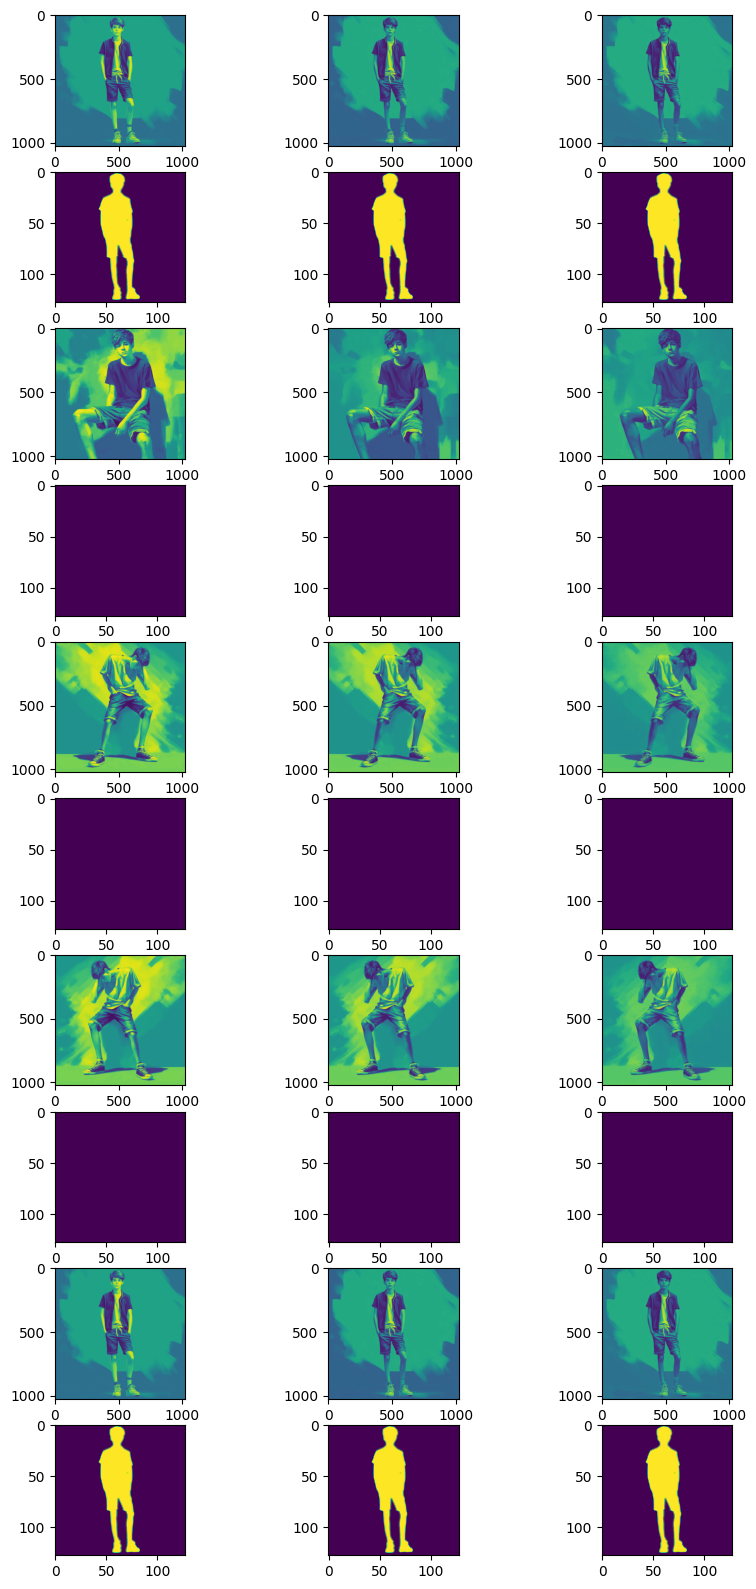

In [118]:
from PIL import Image
import matplotlib.pyplot as plt
train_dataset.image_paths
ds = train_dataset[90]

f, axarr = plt.subplots(10, 3, figsize=(10, 20))

for img_num in range(5):
    for n in range(3):
        axarr[img_num * 2][n].imshow(ds['pixel_values'][img_num][n])
    for n in range(3):
        axarr[img_num * 2 + 1][n].imshow(ds['mask_pixel_values'][img_num][n])
plt.show()

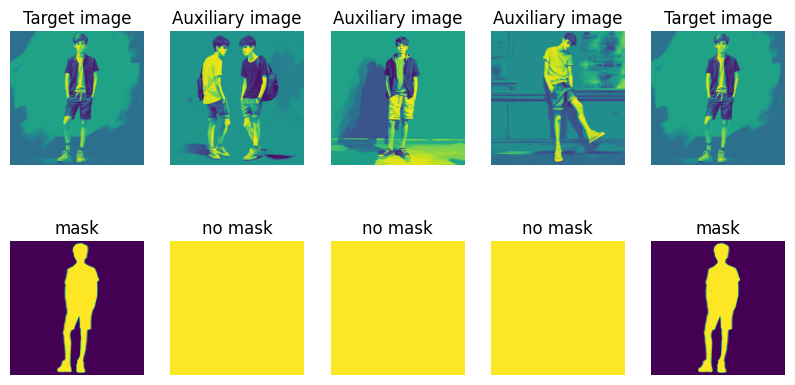

In [126]:
from PIL import Image
import matplotlib.pyplot as plt
train_dataset.image_paths
ds = train_dataset[40]

f, axarr = plt.subplots(2, 5, figsize=(10, 5))

for img_num in range(5):
    axarr[0][img_num].imshow(ds['pixel_values'][img_num][0])
    axarr[1][img_num].imshow(ds['mask_pixel_values'][img_num][0], vmin=0, vmax=1)
    axarr[1][img_num].axis('off')
    axarr[0][img_num].axis('off')
axarr[0][0].set_title('Target image')
axarr[0][1].set_title('Auxiliary image')
axarr[0][2].set_title('Auxiliary image')
axarr[0][3].set_title('Auxiliary image')
axarr[0][4].set_title('Target image')

axarr[1][0].set_title('mask')
axarr[1][1].set_title('no mask')
axarr[1][2].set_title('no mask')
axarr[1][3].set_title('no mask')
axarr[1][4].set_title('mask')
plt.show()
f.savefig(f'batch_example')

$M$ - маска изображения $\mathtt{target}$, $Y$ - таргет модели, $Y_{pred}$ - предсказание модели 

$loss_{OA} = MSE(Y_{pred}, Y)$

$loss_{mask} = MSE
\left(
    \left(
        \left(
    1 - \alpha
        \right)
    I + \bar{\alpha}_t^p \dot \ M 
    \right)
    Y_{pred},
    \left(
        \left(
        1 - \alpha
        \right)
    I + \bar{\alpha}_t^p \dot  M 
    \right)
Y 
\right)$

где $\alpha$ - вес маски, $\bar{\alpha_t}$ - шум на этапе $t$, $p$ - коээфициент

In [99]:
config['target_dir']

'teenager_wearing_shorts_and_canvas_shoes'

In [88]:
!ls ./experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904

base			output_2504151631  reconciliation
config_2504141904.yaml	output_2504151724  reconciliation.ipynb
metric_ds.pickle	output_2504151752  target.jpg
output_16e048a1		output_2504152002  target_mask.png
output_2504151206	output_5f5976e1    xt_list.pkl
output_2504151233	output_66a443a7
output_2504151603	output_bcf97b0c


In [89]:
    # get environment configs
    with open("PATH.json","r") as f:
        ENV_CONFIGS = json.load(f)
    # get user configs

    with open("./config/gen_tune_inference_boy.yaml", "r") as f:
        config = yaml.safe_load(f)
    device = config['device']

    
    target_dir = config['experiments_dir']+'/'+config['target_dir']
    for _, tgt_dirs, _ in os.walk(target_dir):
        break
    if not tgt_dirs:
        print("Base image is not generated")
    if config['target_uuid'] == 'no':
        target_uuid = tgt_dirs[0][4:]
    else:
        if config['target_uuid'] not in tgt_dirs:
            print("No target images") 
        target_uuid = config['target_uuid']

    print(f"target_uuid = {target_uuid}")

    target_dir += f"/{target_uuid}"

target_uuid = exp_2504141904


In [75]:
    accelerator_project_config = ProjectConfiguration(project_dir=target_dir, logging_dir='logs')
    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="no",
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

In [76]:
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

In [77]:
    # If passed along, set the training seed now.
    if config['t_seed'] is not None:
        set_seed(config['t_seed'])
    use_mask = True
    use_zone = False

    mask_alpha = 0.5
    zone_alpha = 0.5
    mask_power = 0.5

    if use_mask and use_zone:
        use_mask = False
        
    # Handle the repository creation
    train_uuid = uuid.uuid4()
    train_uuid = str(train_uuid)[0:8]
    output_dir = f"{target_dir}/output_{train_uuid}"
    if accelerator.is_main_process:
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(f"{output_dir}/ckpt", exist_ok=True)
        os.makedirs(f"{output_dir}/weight", exist_ok=True)
#        shutil.copyfile(args.config_path, f"{output_dir}/config_{train_uuid}.yaml")


In [78]:
    # Load Models
    pretrained_model_name_or_path = ENV_CONFIGS['paths']['sdxl_path']
    # Load the tokenizers
    tokenizer_one = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=None,
        use_fast=False,
    )
    tokenizer_two = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer_2",
        revision=None,
        use_fast=False,
    )


In [79]:
    # import correct text encoder classes
    text_encoder_cls_one = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None
    )
    text_encoder_cls_two = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None, subfolder="text_encoder_2"
    )

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
    # Check for terminal SNR in combination with SNR Gamma
    text_encoder_one = text_encoder_cls_one.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder",
    )
    text_encoder_two = text_encoder_cls_two.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder_2",
    )

    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path, subfolder="unet",
    )


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'thresholding', 'clip_sample_range', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default values.
{'dropout', 'attention_type', 'reverse_transformer_layers_per_block'} was not found in config. Values will be initialized to default values.


In [80]:
    # Freeze vae and text encoders.
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)

    # Build projector
    projector = Projector(1280, 2048)
    # Fire projector
    projector.requires_grad_(True)

    
    if config['use_xformers']:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warn(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if config['allow_tf32']:
        torch.backends.cuda.matmul.allow_tf32 = True


In [81]:
    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        projector.parameters(),  # only optimize the embeddings
        lr=config['lr'],
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-8,
    )


In [82]:
    # Dataset and DataLoaders creation:
    train_dataset = OneActorDataset(
        target_dir=target_dir,
        config=config,
        use_mask=use_mask,
        set='train',
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
    )


In [83]:
train_dataset.image_paths, train_dataset.mask_image_paths

(['experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904/target.jpg'],
 ['experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904/target_mask.png'])

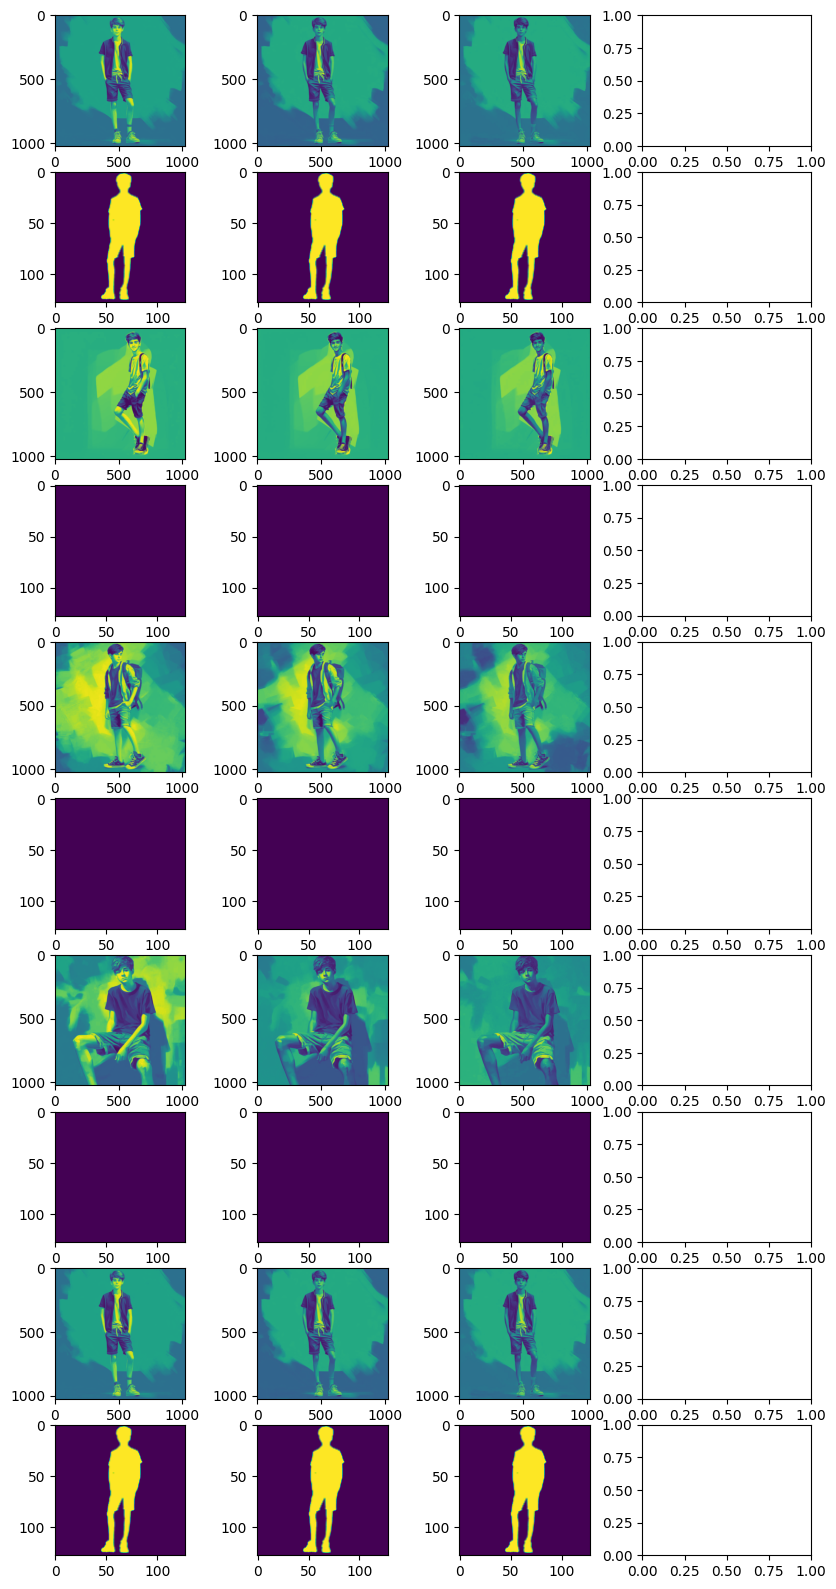

In [85]:
from PIL import Image
import matplotlib.pyplot as plt
train_dataset.image_paths
ds = train_dataset[99]

f, axarr = plt.subplots(10, 4, figsize=(10, 20))

for img_num in range(5):
    for n in range(3):
        axarr[img_num * 2][n].imshow(ds['pixel_values'][img_num][n])
    for n in range(3):
        axarr[img_num * 2 + 1][n].imshow(ds['mask_pixel_values'][img_num][n])
plt.show()

In [17]:
    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader))

    max_train_steps = config['epochs'] * num_update_steps_per_epoch
    overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=500 * accelerator.num_processes,
        num_training_steps=max_train_steps * accelerator.num_processes,
        num_cycles=1,
    )

In [18]:
    projector.train()
    # Prepare everything with our `accelerator`.
    projector, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        projector, optimizer, train_dataloader, lr_scheduler
    )

    # For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    # Move vae and unet to device and cast to weight_dtype

    
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder_one.to(accelerator.device, dtype=weight_dtype)
    text_encoder_two.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader))
    if overrode_max_train_steps:
        max_train_steps = config['epochs'] * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    config['epochs'] = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("OneActor", config=config)


In [19]:
    global_step = 0
    first_epoch = 0
    # Potentially load in the weights and states from a previous save
    if config['resume_from_checkpoint'] is not None:
        # Get the most recent checkpoint
        dirs = os.listdir(output_dir+'/ckpt')
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint does not exist. Starting a new training run."
            )
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(output_dir, 'ckpt', path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch

    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )


Checkpoint does not exist. Starting a new training run.


Steps:   0%|          | 0/600 [00:00<?, ?it/s]

In [32]:
    if use_zone:
        zone = make_zone(128)
        zone = (1-zone_alpha) * torch.ones(size=zone.shape) + zone_alpha * zone
        zone = torch.tensor(zone, device=device).float()

/tmp/ipykernel_1316/4199397275.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zone = torch.tensor(zone, device=device).float()


In [ ]:
    best_loss = 1000.0
    
    if use_mask:  
        alphas_cumprod = torch.pow(noise_scheduler.alphas_cumprod, mask_power).to(device=accelerator.device)
        
    for epoch in range(first_epoch, config['epochs']):
        projector.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(projector):
                # import pdb; pdb.set_trace()
                # Convert images to latent space
   
                images = batch["pixel_values"][0].to(dtype=torch.float32)
                latents = vae.encode(batch["pixel_values"][0]).latent_dist.sample().detach()                    
                latents.to(dtype=torch.float16)
                latents = latents * vae.config.scaling_factor
                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                noise[-1] = noise[0]    # aver is the same as target
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()
                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                if use_mask:            
                    mask_latents = batch["mask_pixel_values"][0].to(dtype=weight_dtype)

                    noisy_mask_latents = alphas_cumprod[timesteps].view(5,-1) \
                            * mask_latents.view(5,-1) \
                        + (1 - alphas_cumprod[timesteps].view(5,-1)) \
                           * torch.ones(size=mask_latents.size()).to(latents.device).view(5, -1)

                    noisy_mask_latents = (1 - mask_alpha) * torch.ones(size=mask_latents.size()).to(latents.device).view(5, -1) \
                        + mask_alpha * noisy_mask_latents
                    noisy_mask_latents = noisy_mask_latents.reshape(5, 4, 128, 128)
                    noisy_mask_latents[1:-1] = torch.ones(size=noisy_mask_latents[1:-1].size()).to(latents.device) # do not apply mask to base  
    
                # time ids
                def compute_time_ids(original_size, crops_coords_top_left):
                    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                    target_size = (1024, 1024)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    with torch.cuda.amp.autocast(dtype=torch.float16):
                        add_time_ids = add_time_ids.to(accelerator.device)
                    return add_time_ids # tensor(1, 6)
                
                original_size = (1024, 1024)
                crops_coords_top_left = (0, 0)
                add_time_ids = compute_time_ids(original_size, crops_coords_top_left).repeat(bsz, 1).to(accelerator.device)
                unet_added_conditions = {"time_ids": add_time_ids}
    
                text_encoders = [text_encoder_one, text_encoder_two]
                tokenizers = [tokenizer_one, tokenizer_two]
                # Get the text embedding for conditioning
                prompt_embeds_batch_list = []
                add_text_embeds_batch_list = []
                delta_emb = projector(batch['h_mid'][0, :, -1].to(device)) # torch.size(bs, 1280, 32, 32) -> torch.size(bs, 2048)
                delta_emb_aver = delta_emb[1:-1].mean(dim=0, keepdim=True)
                for b_s in range(bsz): # 1*target+n*base+1*aver
                    prompt = batch['text'][b_s][0] # str
                    prompt_embeds_list = []
    
                    first = 1
                    for tokenizer, text_encoder in zip(tokenizers, text_encoders):
    
                        text_inputs = tokenizer(
                            prompt,
                            padding="max_length",
                            max_length=tokenizer.model_max_length,
                            truncation=True,
                            return_tensors="pt",
                        )
                        tokens = tokenizer.encode(prompt)
                        
                        if first:
                            for i, token in enumerate(tokens):
                                if tokenizer.decode(token) == batch['base'][0]:
                                    base_token_id = i
                                    first = 0
                                    break
                        text_input_ids = text_inputs.input_ids
                        prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)
                        pooled_prompt_embeds = prompt_embeds[0]
                        prompt_embeds = prompt_embeds.hidden_states[-2]
                        prompt_embeds_list.append(prompt_embeds)
                    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)    # tensor(1, 77, 2048)
    
                    if b_s == bsz-1:
                        delta_emb_ = delta_emb_aver
                    else:
                        delta_emb_ = delta_emb[b_s:b_s+1]
                    prompt_embeds[:, base_token_id, :] = prompt_embeds[:, base_token_id, :] + delta_emb_

                    prompt_embeds_batch_list.append(prompt_embeds)
                    add_text_embeds_batch_list.append(pooled_prompt_embeds)
                
                prompt_embeds = torch.concat(prompt_embeds_batch_list, dim=0)
                add_text_embeds = torch.concat(add_text_embeds_batch_list, dim=0).to(accelerator.device)
    
                unet_added_conditions.update({"text_embeds": add_text_embeds})
                prompt_embeds = prompt_embeds.to(accelerator.device)
    
    
                # Predict the noise residual
                dtype = unet.dtype

                noisy_latents = noisy_latents.to(dtype)
                prompt_embeds = prompt_embeds.to(dtype)
                timesteps = timesteps.to(dtype)
                unet_added_conditions["text_embeds"] = unet_added_conditions["text_embeds"].to(dtype)
                unet_added_conditions["time_ids"] = unet_added_conditions["time_ids"].to(dtype)

                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=prompt_embeds, added_cond_kwargs=unet_added_conditions).sample
    
    
                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if use_mask:
                    loss_target = F.mse_loss(model_pred[:1].float() * noisy_mask_latents[:1].float(),
                                             target[:1].float() * noisy_mask_latents[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float() * noisy_mask_latents[1:-1].float(),
                                             target[1:-1].float() * noisy_mask_latents[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float() * noisy_mask_latents[-1:].float(),
                                             target[-1:].float() * noisy_mask_latents[-1:].float(), reduction="mean")
                elif use_zone:
                    loss_target = F.mse_loss(model_pred[:1].float() * zone[:1], 
                                           target[:1].float() * zone[:1], reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float() * zone[1:-1],
                                           target[1:-1].float() * zone[1:-1], reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float() * zone[-1:],
                                           target[-1:].float() * zone[-1:], reduction="mean")
                else:
                    loss_target = F.mse_loss(model_pred[:1].float(),
                                             target[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float(),
                                             target[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float(),
                                             target[-1:].float(), reduction="mean")
                
                loss = loss_target + config['lambda1'] * loss_base + config['lambda2'] * loss_aver    
                avg_loss = accelerator.gather(loss.repeat(config['batch_size'])).mean()
                train_loss += avg_loss.item()
    
                accelerator.backward(loss)
    
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % config['save_steps'] == 0:
                    weight_name = (
                        f"learned-projector-steps-{global_step}.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    best_step = initial_global_step + global_step
                    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
                    weight_name = (
                        f"best-learned-projector.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )

                if accelerator.is_main_process:
                    if global_step % config['checkpointing_steps'] == 0:
                        save_path = os.path.join(output_dir, 'ckpt', f"checkpoint-{initial_global_step + global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"loss": train_loss, "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            train_loss = 0.0

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
   
    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
    accelerator.end_training()

In [ ]:
noisy_mask_latents.min(), noisy_mask_latents.max() 

In [ ]:
f, axarr = plt.subplots(10, 4, figsize=(10, 30))
for m in range(5):
    for n in range(4):
        axarr[2*m][n].imshow(model_pred[m][n].cpu().detach().numpy())
        axarr[2*m+1][n].imshow(target[m][n].cpu().detach().numpy())
plt.show()


In [ ]:
timesteps

In [ ]:
f, axarr = plt.subplots(10, 4, figsize=(10, 25))
for m in range(5):
    for n in range(4):
        axarr[2*m][n].imshow(latents[m][n].cpu())
        axarr[2*m+1][n].imshow(noisy_latents[m][n].cpu())
plt.show()

In [ ]:
f, axarr = plt.subplots(10, 4, figsize=(10, 25))
for m in range(5):
    for n in range(4):
        axarr[2*m][n].imshow(mask_latents[m][n].cpu())
        axarr[2*m+1][n].imshow(noisy_mask_latents[m][n].cpu())
plt.show()

In [ ]:
noisy_mask_latents.min(), noisy_mask_latents.max() 